# What this graph is about

Data of this graph was collected from the study of the paper [[3]](../README.md#references).

The aim of the graph is to understand better the connections and structor of neurons in the primary visual cortex of a mouse.

Researchers have simulated visual stimulus on some neurons and tracked where the synapsis were propagated or not.

## Data components

Three types of components were tracked:

- Characterized pyramidal neuron
- Cell body in EM volume
- Dendritic fragment

We will try to get a brief explanation of these components.

### Characterized pyramidal neuron

These are the neurons that were stimulated with two-photon calcium imaging. A specific visual 
stimulus is created with this technique.

> Every synapse starts from one of them.

### Cell body in EM volume

These are the neurons that are targeted from the synapse. With the large-scale electron microscopy (EM), like we described in the [README](../README.md#scope-of-the-paper), is it possible 
to trace a portion of the local network of these neurons.

### Dendritic fragment

Part of the neuron specialized in retrieving signals from other neurons. It is different from the 
axon which is specialized in sending signals to other neurons.

> We have *fragment* because the Dendritic is highly branched, so only a fraction of it was tracked.   

## Further division of the components

We said that a **pyramidal neuron** "starts" the synapse targeting a specific neuron.

Post-Synaptic data was also collected, so the components: *Cell body in EM volume* and *Dendritic fragment* can be classified to:

- Postsynaptic excitatory target,
- Postsynaptic inhibitory target

**excitatory** and **inhibitory** means: "A target that *propagates* the signal and a target that *stops* the signal respectively."

> Since all the synapses start from the *characterized pyramidal neurons*, they do not have this further division and that attribute is marked as *NA*.
 

# Before Starting the analysis

Now that we know **what** data is collected, **why** and **how**, we can formulate questions.

This is an important step because we must know what we are looking for, otherwise we might not be able to see it if we find it.

We can split the techniques to answer the questions, and the rest of the notebook, in two categories:

1. [Descriptive analysis](#descriptive-analysis)
2. [Statistical modeling](#statistical-modeling)

> We will not use any machine learning technique, since is out of the scope of this course. 
> We will focus on the statistical aspects of Network data.


# Descriptive analysis

We now start from the descriptive analysis since is easier and let's us take confidence with these dataset.

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import random

First step is to importing the graph downloaded from the site [[2]](/README.md#references).

Unfortunately with this version we are using of iGraph, we can't read from an URL.

The data was downloaded and put in the [Data](../Data/mouse_visual.cortex_2.graphml) folder.

In [2]:
neurons : ig.Graph
neurons = ig.Graph.Read_GraphML("../Data/mouse_visual.cortex_2.graphml")
neurons.to_directed()

> Since the return type of `Read_GraphML` is erroneously hinted as `None` (which is not because is a `Graph`) we hint the interpreter thar `neurons` is a `Graph`, so we can use autocompletion and suggestions.

As we saw before, we have three types of nodes in this network and are described as nodal attributes of name `type1`

In [3]:
print(f"The three node possible types are : {set(neurons.vs['type1'])}")

The three node possible types are : {'Cell body in EM volume', 'Characterized pyramidal neuron', 'Dendritic fragment'}


Furthermore if a node is a Postsynaptic target, i.e. if a node is not a `Characterized pyramidal neuron`, 
we have two others classifications:

In [4]:
print(f"We can further classify as: {set(neurons.vs['type2'])}")

We can further classify as: {'NA', 'Postsynaptic excitatory target', 'Postsynaptic inhibitory target'}


The fact that if a node is a `Characterized pyramidal neuron` then the attribute `type2` is `NA`, 
can be proved with the following lines of code.

In [5]:
def check_type1_can_only_be_type2(graph:ig.Graph,type1:str,type2:str) -> bool:
    for node in list(graph.vs):
        if node["type1"] == type1:
             if not (node["type2"] == type2):
                return False
    return True
print("{type1} can only be {type2}: {assertion}.".format(type1='Characterized pyramidal neuron',type2 = 'NA', assertion = check_type1_can_only_be_type2(neurons,'Characterized pyramidal neuron','NA')))

Characterized pyramidal neuron can only be NA: True.


## Plotting the network

Let's now plot the data.

We will use `matplotlib` for backend.

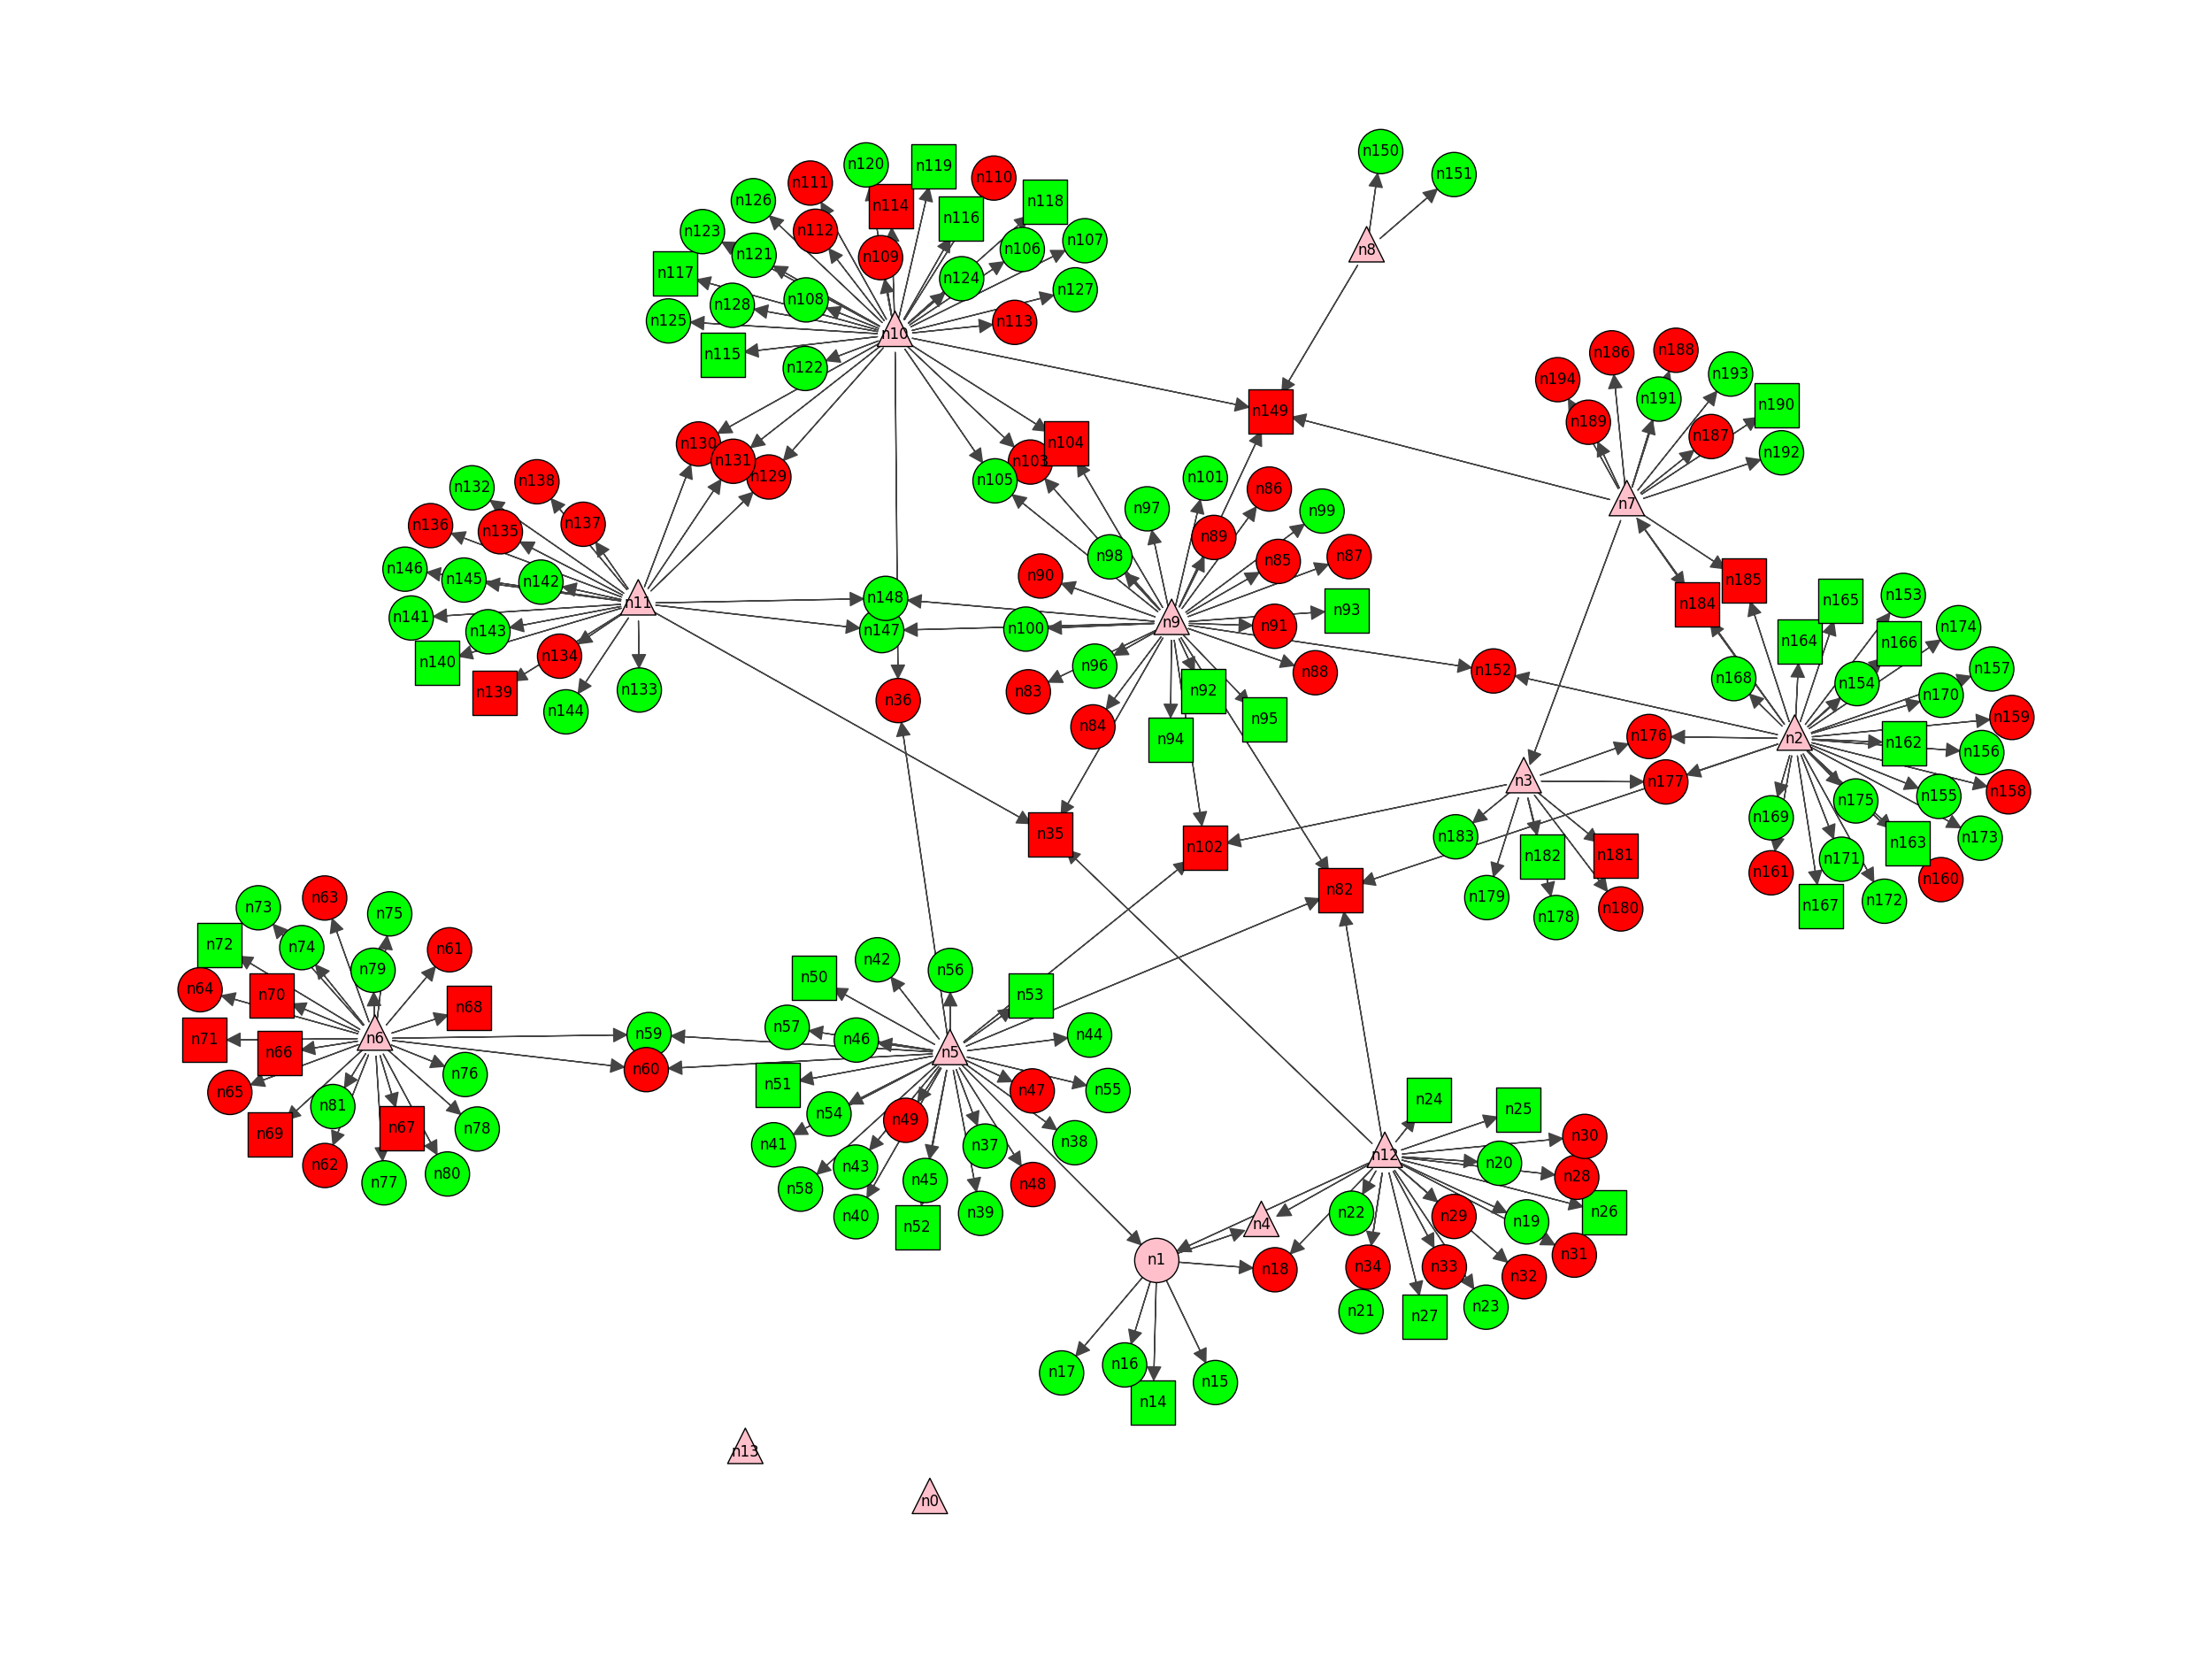

In [6]:
random.seed(42)

fig, ax = plt.subplots(figsize=(32,24))
ig.plot(
    neurons,
    target=ax,
    layout="fruchterman_reingold",
    vertex_shape = ["circle" if type == "Dendritic fragment" else "square" if type == "Cell body in EM volume" else "triangle" for type in neurons.vs["type1"]],
    vertex_size=[40 if type == "Characterized pyramidal neuron" else 50 for type in neurons.vs["type1"]],
    vertex_label=neurons.vs["id"],
    vertex_color=["green" if type == "Postsynaptic excitatory target" else "red" if type == "Postsynaptic inhibitory target" else "pink" for type in neurons.vs["type2"]],
    edge_width = 1
)
plt.gcf().set_facecolor('none')
plt.savefig("../Plots/neurons.png",transparent=True)
plt.show()

## Network Statistics

We now start to deep dive in to the graph structure, calculating and interpreting the major networks statistics.

We will use the following statistics:

- [Density](#density)
- [Reciprocity](#reciprocity)
- [Transitivity (undirected case)](#transitivity)
- [Modularity/Assortative Mixing](#modularity)

> All the network statistics are linked to the corresponding section.

Each of these statistics answer a different and a specific question which we will analyze one by one.

A recap of all these statistics are in [this](#recap-of-the-network-statistics) section.


### Density

**QUESTION**

*How connected is the graph?*

The density $\rho$ strictly lies between $0 \leq \rho \leq 1$.

If the density approaches 0 it means that the graph is *sparse*, if it approaches 1 it is said to be *dense*.

Density is also an estimate of the probability of observing a tie between randomly sampled nodes.

> Documentation of the method can be found [here](https://python.igraph.org/en/latest/api/igraph.GraphBase.html#density).


In [7]:
density = neurons.density(loops = False)
print(f"The density of the graph is: {density:.4f}")
print(f"The probability of observing a random tie is {density*100:.2f}%")

The density of the graph is: 0.0057
The probability of observing a random tie is 0.57%


As we can see the network is sparse. If we go back to the [plot](#plotting-the-network) we can observe that indeed the graph is sparse and the majority of ties are the ones that forms stars with *Characterized pyramidal neurons* as the centers.

### Reciprocity

**Question**

*How strong is the tendency to return a tie in the network?*

The reciprocity coefficient $R$ lies in the range $0 \leq R \leq 1$.

The more this value is 0, the more relations observed between nodes in the
network are **not** reciprocated.

Value close to 1 means relations observed between nodes in the
network are reciprocated.

For what we know from our assumptions (i.e.) *All the synapses starts from a Characterized pyramidal neuron and the path have length 1*, we expect that this statistic approaches 0.

> Documentation of the method can be found [here](https://python.igraph.org/en/latest/api/igraph.GraphBase.html#reciprocity).

In [8]:
reciprocity = neurons.reciprocity()
print(f"The reciprocity of the graph is: {reciprocity:.1f}")

The reciprocity of the graph is: 0.0


Indeed the reciprocity is 0, in fact no node returns a tie in the network.

In our case we do not have enough information to state if in the reality the reciprocity is higher, because the data collected from the experiment contains only one step of the path of the propagation of the stimulation. 

### Transitivity

**Question**

*What proportion of triangle do we observe in the network?*

Transitivity is the ratio of the triangles and connected triplets in the graph.

In a social graph the question could be: *Are friends of friends also friends?*

In our case, finding a triangle is an interesting issue for understanding the structor of the visual cortex. However, as we stated before, path collected are of length one, so we expect that ever this statistic approaches to 0.

> Documentation of the method can be found [here](https://python.igraph.org/en/latest/api/igraph.GraphBase.html#transitivity_undirected).

In [9]:
transitivity = neurons.transitivity_undirected()
print(f"Transitivity of the graph is: {transitivity:.4f}")

Transitivity of the graph is: 0.0047


The transitivity is not 0, this means that there is at least 1 triangle. Still the statistic approaches 0, this means that in general we can expect no triangle.

Going back to the [plot](#plotting-the-network) we can see a triangle on the bottom-right of the plot, composed by node 1, 12 and 18.

For simplicity a subgraph of that triangle is reported below.

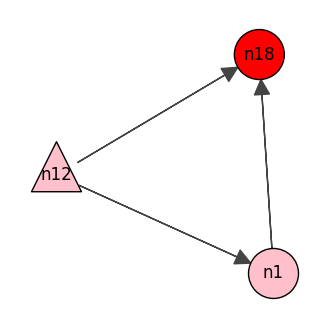

In [10]:
ids = ["n1","n12","n18"]
vertex_idx = [v.index for v in neurons.vs if v["id"] in ids]
triangle = neurons.subgraph(vertex_idx)

random.seed(42)
fig, ax = plt.subplots(figsize=(4,4))
ig.plot(
    triangle,
    target=ax,
    layout="fruchterman_reingold",
    vertex_shape = ["circle" if type == "Dendritic fragment" else "square" if type == "Cell body in EM volume" else "triangle" for type in triangle.vs["type1"]],
    vertex_size=[50 if type == "Characterized pyramidal neuron" else 50 for type in triangle.vs["type1"]],
    vertex_label=triangle.vs["id"],
    vertex_color=["green" if type == "Postsynaptic excitatory target" else "red" if type == "Postsynaptic inhibitory target" else "pink" for type in triangle.vs["type2"]],
    edge_width = 1
)

plt.gcf().set_facecolor('none')
plt.savefig("../Plots/triangle.png",transparent=True)
plt.show()

### Modularity

**Question**

*Are neurons with lot of connections of the same type?*

Indeed we have one particular type of node, which is the *Characterized pyramidal neuron* that have the highest out-degree and the lowest in-degree.

We expect to observe disassortative mixing, because in our case the stimulus starts from a *Characterized pyramidal neuron* and ends up to a *dendritic fragment* or to a *cell body in EM volume*.

The function we use to calculate the modularity coefficient is **not** normalized.

> Documentation of the method can be found [here](https://python.igraph.org/en/latest/api/igraph.GraphBase.html#modularity).

In [11]:
# We have to binarize the qualitative attributes first. 
pyramidal = [1 if x == "Characterized pyramidal neuron" else 0 for x in neurons.vs["type1"]]
dendritic = [1 if x == "Dendritic fragment" else 0 for x in neurons.vs["type1"]]
cell = [1 if x == "Cell body in EM volume" else 0 for x in neurons.vs["type1"]]

# Now we can calculate modularity with respect to each qualitative attribute
pyramidal_modularity = neurons.modularity(pyramidal)
dendritic_modularity = neurons.modularity(dendritic)
cell_modularity = neurons.modularity(cell)

print(f"Modularity for Characterized pyramidal neuron is: {pyramidal_modularity:.5f}")
print(f"Modularity for Dendritic fragment is: {dendritic_modularity:.5f}")
print(f"Modularity for Cell body in EM volume is: {cell_modularity:.5f}")

Modularity for Characterized pyramidal neuron is: -0.00830
Modularity for Dendritic fragment is: -0.00271
Modularity for Cell body in EM volume is: 0.00000


The modularity coefficient that we use is strictly less then 1.

We just interpreter the first one, *Modularity for Characterized pyramidal neuron* since the other to are not usefully for our analysis. This coefficient is negative, so it indicate disassortative mixing as we expected. We can conclude that *Characterized pyramidal neuron* **don't** form ties between them.

### Recap of the network statistics

We plot a table that summarize all the network statistics calculated until now.

In [12]:
import pandas as pd

network_stats_dic = {
    "network_statistics": ["Density", "Reciprocity", "Transitivity", "Modularity"],
    "values": [density, reciprocity, transitivity, pyramidal_modularity]
}

network_stats = pd.DataFrame(network_stats_dic)
network_stats.set_index("network_statistics", inplace=True)
network_stats.T.head()


network_statistics,Density,Reciprocity,Transitivity,Modularity
values,0.005657,0.0,0.004687,-0.008298


## Nodal Statistics

We can now use some centrality measure to spot important nodes given a specific criteria.

We will use the following centrality mesures:

- [Degree](#degree-centrality)
- [Closeness](#closeness-centrality)
- [Betweenness](#betweenness-centrality)
- [Eigenvector](#eigenvector-centrality)

All this centrality measure will be also incorporated to the corresponding centralization index. The interpretation varies depending on the measure used.

> Centralization index is not provided in python-igraph, however is easy to implement and we provide these methods in the following [module]().

For simplify the visualization and the comparison of vertex centrality measures, we create a DataFrame to store information of the nodes and the relatives measurements.

In [13]:
data = {
    "id": neurons.vs["id"],
    "type1": neurons.vs["type1"],
    "type2": neurons.vs["type2"]
}
centrality = pd.DataFrame(data)
centrality.tail(2)

,id,type1,type2
193,n193,Dendritic fragment,Postsynaptic excitatory target
194,n194,Dendritic fragment,Postsynaptic inhibitory target


> The index of the rows corresponds to the attribute id of the nodes.

### Degree Centrality

We define a node important if it is connected to many other nodes.

We have a directed graph, so we can distinguish between in and out degree, or we can consider the support of the graph.

In our case it makes more sense to consider a node important if it has high **in** degree, because every stimulus starts from a known pyramidal with high out degree, so it doesn't make sense to consider important those kind of nodes.

The nodes with high in degree are the ones more targeted to propagate or inhibit the stimulus. We consider this type of nodes important.

> Base method documentation can be found [here](https://python.igraph.org/en/latest/api/igraph.GraphBase.html#degree).

In [14]:
centrality["in_degree"] = neurons.degree(centrality.index,mode="in")
centrality["in_degree_std"] = centrality["in_degree"]/centrality["in_degree"].max()
print(f"The maximum in-degree is: {centrality["in_degree"].max()}")
centrality.sort_values(by=["in_degree"], ascending=False).head(3)[["type1","type2","in_degree_std"]]

The maximum in-degree is: 4


,type1,type2,in_degree_std
149,Cell body in EM volume,Postsynaptic inhibitory target,1.00
82,Cell body in EM volume,Postsynaptic inhibitory target,1.00
102,Cell body in EM volume,Postsynaptic inhibitory target,0.75


We can see that `in_degree` is relatively low and the maximal value is 4.

It's important to note that the most important nodes, based on in degree centrality, are all `Postsynaptic inhibitory target`.

In [15]:
from centralization.centralization_index import degree_centralization

degree = degree_centralization(neurons,"in")
print(f"Network degree centralization (standardized): {degree:.03}")

Network degree centralization (standardized): 0.015


Based on the network degree centralization, we can conclude that there are no extremely important nodes. That makes sense because if there were few extremely important neurons, "loosing" them implies that all the visual cortex will become unusable and that is a too fragile system.

### Closeness Centrality

We define a node important if it is close to many other nodes.

For calculating this measure we have to calculate every shortest path. This computation is expensive and there are may tricks to approximate this measure, (i.e.) using sketches. In our case, since the graph is small, we relay on the exact measure provided by python-igraph.

Since we have a directed graph we have to choose if the calculation must be applied considering in-edges, out-edges or the undirected case. Undirected case will gives us that "Characterized pyramidal neuron" is indeed important, but we already know that. For this reason we choose to consider in-edges important.

> Base method documentation can be found [here](https://python.igraph.org/en/latest/api/igraph.GraphBase.html#closeness).

In [16]:
centrality["in_closeness_std"] = neurons.closeness(mode="in",normalized=True)
centrality.sort_values(by=["in_closeness_std"], ascending=False).head(3)[["type1","type2","in_closeness_std"]]

,type1,type2,in_closeness_std
184,Cell body in EM volume,Postsynaptic inhibitory target,1.0
185,Cell body in EM volume,Postsynaptic inhibitory target,1.0
19,Dendritic fragment,Postsynaptic excitatory target,1.0


Here things are interesting, because the majority of nodes ($\approx \frac{3}{4}$) have standardized closeness equal to 1.

If all nodes in a graph have the same closeness centrality along a specific path, it could indicate a well-balanced network structure where all nodes are equally important and interconnected. This scenario suggests strong connectivity and a balanced distribution of the nodes' roles in transmitting information along the specified path.

### Betweenness Centrality

In [17]:
centrality["betweenness"] = neurons.betweenness(directed=True)
centrality["betweenness_std"] = centrality["betweenness"]/centrality["betweenness"].max()
centrality.sort_values(by=["betweenness_std"], ascending=False).head(3)[["type1","type2","betweenness_std"]]

,type1,type2,betweenness_std
7,Characterized pyramidal neuron,NA,1.000000
3,Characterized pyramidal neuron,NA,0.888889
1,Dendritic fragment,NA,0.555556


### Eigenvector Centrality

In [18]:
centrality["eigenvector"] = neurons.eigenvector_centrality(directed=True,scale=False)
centrality["eigenvector_std"] = centrality["eigenvector"]/centrality["eigenvector"].max()
centrality.sort_values(by=["eigenvector_std"], ascending=False).head(3)[["type1","type2","eigenvector_std"]]

/tmp/ipykernel_37173/1211845806.py:1: RuntimeWarning: Graph is directed and acyclic; eigenvector centralities will be zeros. at src/centrality/eigenvector.c:284
  centrality["eigenvector"] = neurons.eigenvector_centrality(directed=True,scale=False)


,type1,type2,eigenvector_std
0,Characterized pyramidal neuron,NA,NaN
1,Dendritic fragment,NA,NaN
2,Characterized pyramidal neuron,NA,NaN
